In [1]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 69.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 42.9 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fo

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [4]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [7]:
747/4825

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
3530,spam,Xmas & New Years Eve tickets are now on sale f...,1
2089,spam,Well done ENGLAND! Get the official poly ringt...,1
2561,ham,Are you still getting the goods.,0
1765,spam,Hi 07734396839 IBH Customer Loyalty Offer: The...,1
139,spam,You'll not rcv any more msgs from the chat svc...,1


Split it into training and test data set

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

Now lets import BERT model and get embeding vectors for few sample statements

In [15]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [16]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351724, -0.5132727 , -0.88845736, ..., -0.7474883 ,
        -0.75314754,  0.91964495],
       [-0.87208354, -0.50543964, -0.94446665, ..., -0.85847497,
        -0.71745336,  0.88082975]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [17]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [19]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [20]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

In [21]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [23]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

Train the model

In [24]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 24s 327ms/step - loss: 0.7183 - accuracy: 0.5536 - precision: 0.5464 - recall: 0.6304
Epoch 2/10
35/35 [==============================] - 11s 314ms/step - loss: 0.5656 - accuracy: 0.7295 - precision: 0.7429 - recall: 0.7018
Epoch 3/10
35/35 [==============================] - 12s 341ms/step - loss: 0.4948 - accuracy: 0.8116 - precision: 0.7923 - recall: 0.8446
Epoch 4/10
35/35 [==============================] - 12s 333ms/step - loss: 0.4415 - accuracy: 0.8491 - precision: 0.8297 - recall: 0.8786
Epoch 5/10
35/35 [==============================] - 12s 335ms/step - loss: 0.4183 - accuracy: 0.8455 - precision: 0.8263 - recall: 0.8750
Epoch 6/10
35/35 [==============================] - 11s 320ms/step - loss: 0.3804 - accuracy: 0.8670 - precision: 0.8477 - recall: 0.8946
Epoch 7/10
35/35 [==============================] - 12s 340ms/step - loss: 0.3632 - accuracy: 0.8759 - precision: 0.8538 - recall: 0.9071
Epoch 8/10
35/35 [================

In [25]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 6s 313ms/step - loss: 0.3028 - accuracy: 0.9118 - precision: 0.9053 - recall: 0.9198


[0.30279284715652466,
 0.9117646813392639,
 0.9052631855010986,
 0.9197860956192017]

In [26]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 6s 303ms/step


In [27]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1,

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[169,  18],
       [ 15, 172]])

Text(50.722222222222214, 0.5, 'Truth')

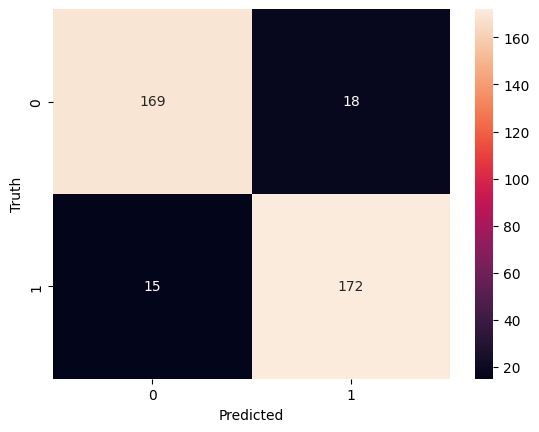

In [29]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')


In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       187
           1       0.91      0.92      0.91       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374

